In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import pydicom
from pydicom.data import get_testdata_files
from ipywidgets import widgets, Layout, interact, fixed
from IPython.display import display
from IPython.display import clear_output

### Core

In [4]:
def bresenham(p0, p1):
    pts = []
    x0, y0 = p0
    x1, y1 = p1

    dx = abs(x1-x0)
    dy = abs(y1-y0)
    
    if x0 < x1:
        sx = 1
    else:
        sx = -1
        
    if y0 < y1:
        sy = 1
    else:
        sy = -1
        
    err = dx-dy
    while True:
        pts.append((x0,y0))
        if x0 == x1 and y0 == y1:
            return pts
        
        e2 = 2*err
        if e2 > -dy:
            # overshot in the y direction
            err = err - dy
            x0 = x0 + sx
        if e2 < dx:
            # overshot in the x direction
            err = err + dx
            y0 = y0 + sy
            
            
def rotate_line(line, origin, angle):
    origin_x, origin_y = origin
    rotated_line = []
    for point in line:
        x, y = point
        rotated_x = int(origin_x + math.cos(angle) * (x - origin_x) - math.sin(angle) * (y - origin_y))
        rotated_y = int(origin_y + math.sin(angle) * (x - origin_x) + math.cos(angle) * (y - origin_y))
        rotated_line.append((rotated_x, rotated_y))
    return rotated_line

#generates emitters and detectors vertically
def gen_emitters_and_detectors(n, angle, gray):
    x,y = gray.shape
    r=math.sqrt(x**2 + y**2)/2
    l = int(2 * (r * math.sin((angle*math.pi/180)/2) ))
    emitters = [(int(pos),int(y/2 + r)) for pos in np.linspace(int(x/2 - l/2), int(x/2 + l/2), n)]
    detectors = [(int(pos),int(y/2 - r)) for pos in np.linspace(int(x/2 - l/2), int(x/2 + l/2), n)]
    return emitters, detectors


def gen_sinogram(n,angle, alphaStepDeg, img):
    gray =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x,y = gray.shape
    lines = []
    all_lines=[]
    em, det = gen_emitters_and_detectors(n, angle, gray)
    for p1,p2 in zip(em, det):
        lines.append(bresenham(p1,p2))
        
    sinogram = np.zeros((n, math.ceil(360/alphaStepDeg)))
    i=0
    for alpha in range(0,360,alphaStepDeg):
        rotated = []
        for line in lines:
            rot_line = rotate_line(line, (int(x/2), int(y/2)), (alpha/180)*math.pi)
            new_line = [(px ,py) for px,py in rot_line if 0 < px < x and 0 < py < y]
            rotated.append(new_line)
            
        all_lines.append(rotated)
        for j, line in enumerate(rotated):
            sinogram[j,i] = sum([gray[point] for point in line])
        i+=1
        
    sinogram = sinogram / sinogram.max()
    return sinogram, all_lines

def restore_picture(sinogram, lines, picture_shape):
    x,y = picture_shape[0], picture_shape[1]
    b = max(picture_shape)
    
    restoration = np.zeros((x,y)) 
    count_matrix = np.zeros((x,y))
    
    for i, lines_for_alpha in enumerate(lines):
        for j, line in enumerate(lines_for_alpha):
            for px, py in line:
                    restoration[px,py] += sinogram[j, i]
                    count_matrix[px,py] += 1
                    
    for i in range(count_matrix.shape[0]):
        for j in range(count_matrix.shape[1]):
            if count_matrix[i,j] != 0:
                restoration[i,j] /= count_matrix[i,j]
                
    return restoration

def conv1d(X,H):
    m=len(X);
    n=len(H);
    Y = np.zeros(m+n-1)
    for i in range(n + m -1):
        Y[i]=0;
        for j in range(m):
            if i-j+1>0 and i-j+1<len(H):
                Y[i]=Y[i]+X[j]*H[i-j+1]
    return Y

def conv1d_simple(sinus, simple_kernel):
    copy = sinus.copy()
    for i in range(1,len(sinus)-1):
        copy[i] = simple_kernel[0]*sinus[i-1] + simple_kernel[1] *sinus[i] + simple_kernel[2]*sinus[i+1]
    return copy


def genKernel(size):
    kernel = []
    for i in range(-int(size/2), int(size/2)):
        if i == 0:
            kernel.append(1)
        elif i % 2 == 0:
            kernel.append(0)
        else:
            kernel.append((-4/(math.pi**2))/i**2)    
    return kernel

def convolve_sinogram(sinogram):
    copy = np.zeros(sinogram.shape)
    for i in range(sinogram.shape[1]):
        convolution = conv1d(sinogram[:,i], genKernel(len(sinogram[:,i])))
        convolution = np.append(convolution, 0)
        copy[:,i] = convolution.reshape(-1, 2).mean(axis=1)
    return copy


def convolve_simple(sinogram, simple_kernel):
    copy = np.zeros(sinogram.shape)
    for i in range(sinogram.shape[1]):
        convolution = conv1d_simple(sinogram[:,i], simple_kernel)
        copy[:,i] = convolution
    return copy

### Interactive core

In [70]:
def i_gen_sinogram(count_matrix, sinogram, all_lines, n, angle, alphaStepDeg, img, iterations=0):
    gray =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x,y = gray.shape
    lines = []
    em, det = gen_emitters_and_detectors(n, angle, gray)
    for p1,p2 in zip(em, det):
        lines.append(bresenham(p1,p2))
        
    alpha = iterations*alphaStepDeg
    rotated = []
    for line in lines:
        rot_line = rotate_line(line, (int(x/2), int(y/2)), (alpha/180)*math.pi)
        new_line = [(px ,py) for px,py in rot_line if 0 < px < x and 0 < py < y]
        for point in new_line:
            count_matrix[point] += 1
        rotated.append(new_line)

    all_lines.append(rotated)
    for j, line in enumerate(rotated):
        sinogram[j,iterations] = sum([gray[point] for point in line])
        
    sinogram = sinogram / sinogram.max()
    show_img(sinogram)
        
def i_restore_picture(restoration, count_matrix, sinogram, lines, iteration=0):
    lines_for_alpha = lines[iteration]
    for j, line in enumerate(lines_for_alpha):
        for px, py in line:
                restoration[px,py] += sinogram[j, iteration]
    restoration = restoration / restoration.max()
    show_img(restoration)

### Interface

Text(value='img/skull3.JPG', placeholder='filename')

IntText(value=100, description='resize x_dim to:')

IntText(value=100, description='resize y_dim to:')

IntText(value=180, description='l (deg)')

IntText(value=50, description='n (detectors)')

IntText(value=2, description='∆α (deg)')

Checkbox(value=False, description='filtering')

Checkbox(value=False, description='show intermediate steps')

Button(button_style='success', description='Run', style=ButtonStyle())

Reading an image...


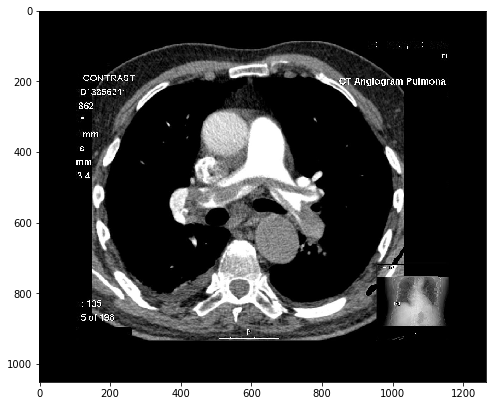

Generating sinogram...


interactive(children=(IntSlider(value=0, description='iterations', max=179), Output()), _dom_classes=('widget-…

interactive(children=(IntSlider(value=0, description='iteration', max=179), Output()), _dom_classes=('widget-i…

Button(button_style='info', description='Clear', style=ButtonStyle())

In [71]:
filename_text = widgets.Text(
    placeholder='filename',
    disabled=False,
    value='img/skull3.JPG'
)

x_dim = widgets.IntText(
    value=100,
    description='resize x_dim to:',
    disabled=False
)

y_dim = widgets.IntText(
    value=100,
    description='resize y_dim to:',
    disabled=False
)

l_val = widgets.IntText(
    value=180,
    description='l (deg)',
    disabled=False
)

n_val = widgets.IntText(
    value=50,
    description='n (detectors)',
    disabled=False
)

step = widgets.IntText(
    value=2,
    description='∆α (deg)',
    disabled=False
)

run_button = widgets.Button(
    description='Run',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
)

clear_button = widgets.Button(
    description='Clear',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
)

filtering_checkbox = widgets.Checkbox(
    value=False,
    description='filtering',
    disabled=False
)

show_intermediate_steps = widgets.Checkbox(
    value=False,
    description='show intermediate steps',
    disabled=False
)

def show_img(img):
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap='gray')
    plt.show()

    
def display_interface():
    display(filename_text)
    display(x_dim)
    display(y_dim)
    display(l_val)
    display(n_val)
    display(step)
    display(filtering_checkbox)
    display(show_intermediate_steps)
    display(run_button)
    
def clear(arg):
    clear_output(True)
    display_interface()
    
    
def transform_without_intermediate_steps():
    print("Reading an image...")
    img = plt.imread(filename_text.value)
    show_img(img)
    img = cv2.resize(img,(x_dim.value,y_dim.value))
    print("Generating sinogram...")
    sinogram, lines = gen_sinogram(n_val.value, l_val.value, step.value, img)
    show_img(sinogram)   
    print("Backprojection without convolution...")
    restored = restore_picture(sinogram, lines, img.shape)
    show_img(restored)
    if filtering_checkbox.value == True:
        print("Performing convolution...")
        convolved_sinogram = convolve_simple(sinogram, [-2,5.5,-2])
        copy = convolved_sinogram.copy()
        convolved_sinogram = convolved_sinogram / convolved_sinogram.max()
        convolved_sinogram[copy < 0] = 0
        print("Convolved sinogram:")
        show_img(convolved_sinogram)
        print("Backprojection from convolved sinogram...")
        restored = restore_picture(convolved_sinogram, lines, img.shape)
        show_img(restored)
        print("Gamma correction:")
        restored = restored ** 2
        restored = restored / restored.max()
        restored = restored * 255
        show_img(restored)
    
def transform_interactively():   
    print("Reading an image...")
    img = plt.imread(filename_text.value)
    show_img(img)
    img = cv2.resize(img,(x_dim.value,y_dim.value))
    print("Generating sinogram...")
    maxx = int(360/step.value)-1
    sinogram = np.zeros((n_val.value, math.ceil(360/step.value)))
    lines=[]
    restoration = np.zeros(img.shape) 
    count_matrix = np.zeros(img.shape)
    interact(i_gen_sinogram, count_matrix=fixed(count_matrix), sinogram=fixed(sinogram), all_lines=fixed(lines), n=fixed(n_val.value), angle=fixed(l_val.value), alphaStepDeg=fixed(step.value), img=fixed(img), iterations = (0,maxx,1))
    interact(i_restore_picture,restoration=fixed(restoration), count_matrix=fixed(count_matrix), sinogram=fixed(sinogram), lines=fixed(lines), iteration=(0,maxx,1))
    
def run_transformation(arg):
    if show_intermediate_steps.value == True:
        transform_interactively()
    else:
        transform_without_intermediate_steps()
    display(clear_button)

display_interface()
clear_button.on_click(clear)
run_button.on_click(run_transformation)